In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

from IPython import display

from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [3]:
DATA_FOLDER = './torch_data/VGAN/MNIST'


In [4]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)


In [5]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

7.3%

100.0%


Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw



100.0%

Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw




100.0%

Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw


100.0%

Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw



In [6]:
#3 hidden layer descriminitive nn to distinguish real and generated data; binary classification (real vs generated data).
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        #number of features in each input image
        n_features = 784
        #output a single scalar value
        n_out = 1
        
        #the 3 hidden layers consist of a linear transformation, LeakyReLu activation, and dropout layer
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        #output layer is a linear transformation and a sigmoid activiation function
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    #forward pass, 'x' is passed through the three hidden layers as described above.
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

#Takes a  batch of image tensors and reshapes them into vectors    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

#Takes a batch of vectors as as input and reshapes them into image tensors; converts the output of the NN from vector to image
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)


In [7]:
#3 layer generator nn, generates images from data.
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        #dimensionality of the input noise vector; in this instance takes 100-dimensional noise vector as input
        n_features = 100
        #number of features in each generated output (784 because 28x28 pixel images)
        n_out = 784
        
        #3 hidden layers consist of linear transformation and then LeakyReLU activation
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        #Output layer using linear transformation and then a hyperbolic tangent activation function.
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    #Forward pass, takes input 'x' and passes it through the 3 hidden layers and output layer as described above
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise, generates noise vectors
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n


In [8]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()


In [9]:
# Optimizers, uses Adam optimizer
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function, Binary Cross Entropy Loss
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200


In [10]:
#Create target tensors for real dn fake data samples.

#Creates a tensor filled with ones with a shape specified by 'size'.  It's the target labels for the real data samples.
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

#Creates a tesnor filled with zeros with a shape specified by 'size'.  It's the target labels for the fake data samples.
def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data


In [11]:
#The discriminator is updated to better distinguish between real and fake data, and then the generator is updated to produce more convincing fake data.

#Trains the discriminator neural network.
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

#Trains the generator neural network.
def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error


In [12]:
num_test_samples = 16
test_noise = noise(num_test_samples)


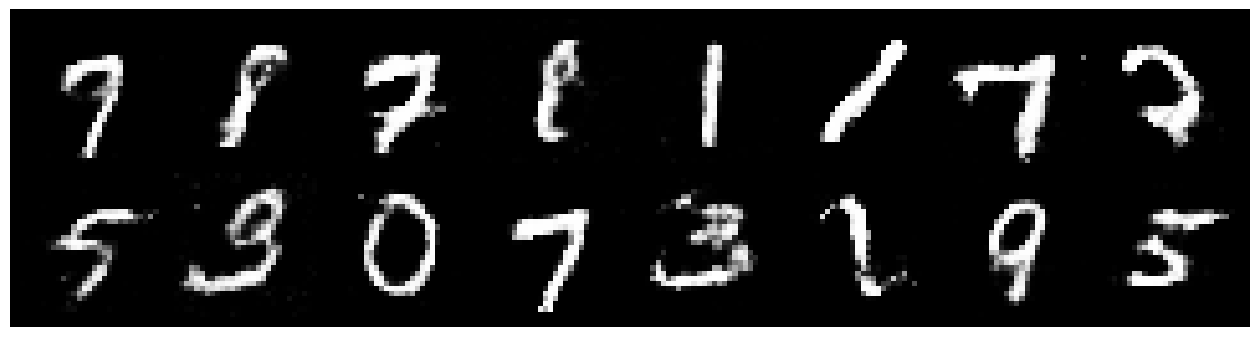

Epoch: [199/200], Batch Num: [500/600]
Discriminator Loss: 1.2715, Generator Loss: 0.8783
D(x): 0.5410, D(G(z)): 0.4441


In [13]:
#Training of GAN to generate images.

logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)
